# Plotting POL-2 data




packages I use:

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ImageNormalize, SqrtStretch
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.coordinates import SkyCoord


from astropy.table import Table, Column
import astropy.units as u
import numpy as np
import aplpy

/Users/hparsons/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


For jupyter notebook I need plotting to be "inline"

In [13]:
%matplotlib inline

# input files

In [14]:
# ndf files neede for this jupyter notebook: if on mac

try:
    print ("running on kukui")
    pol2path = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/noise-investigation/syoyny/'
    pol2path450 = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/450um/syoyny/'
    sc2path = '/export/data2/hparsons/FOP/JellyFish/SCUBA2/Reduced/'
    copath = '/export/data2/hparsons/FOP/JellyFish/HARP/12co/FromParsons2017/'
    
    ndfi = pol2path + 'iext.sdf' # absolute file path
    ndfiauto = pol2path + 'iauto.sdf' # absolute file path
    ndfisnr = pol2path + 'iext_snr.sdf' # absolute file path
    vectorcat = pol2path + 'selcat-5-5-5.FIT' # absolute file path
    vectorcat3 = pol2path + 'selcat-3-3-3.FIT'  
    
    ndfi450 = pol2path450 + 'iext.sdf' # absolute file path
    ndfiauto450 = pol2path450 + 'iauto.sdf' # absolute file path
    ndfisnr450 = pol2path450 + 'iext_snr.sdf' # absolute file path
    vectorcat450 = pol2path450 + 'selcat-i5-p5-pi5.FIT' # absolute file path
    vectorcat3450 = pol2path450 + 'selcat-i3-p3-pi3.FIT'

    ndf850 = sc2path + '850um_corr_map_mJybeam.sdf' # absolute file path
    
    ndf_12co_iwd = copath + 'CO_cube_field_South_1_itd_masked.sdf' # absolute file path
    ndf_12co_integ = copath + 'CO_cube_field_South_1_integ.sdf'
    ndf_12co_integhigh = copath + 'CO_cube_field_South_1_cliphigh_integ.sdf'
    ndf_12co_integlow = copath + 'CO_cube_field_South_1_cliplow_integ.sdf'


except:
    print ("running on mac")

running on kukui


In [15]:
def convert_ndf_to_fits(ndfin):
    '''
    Function takes input ndf and either reports exsiting 
    fits file of the same name or produces a new fits file
    containing the same data. required information = ndf file name
    note fits file goes in same directory as ndf file provided
    '''
    from starlink import convert
    from pathlib import Path
    fitsextension = '.fits'
    filename = ndfin[:-4]
    fitsout = filename+fitsextension
    if Path(fitsout).is_file():
        print("file exists: {}".format(fitsout))
    else:
        convert.ndf2fits(ndfin,fitsout)
        print("file produced: {}".format(fitsout))
    return fitsout


In [16]:
# checking to see if files have fits formats avaliable and if not producing them:

ifits = convert_ndf_to_fits(ndfi)
ifitsauto = convert_ndf_to_fits(ndfiauto)
ifitssnr = convert_ndf_to_fits(ndfisnr)
fits850 = convert_ndf_to_fits(ndf850)


ifits450 = convert_ndf_to_fits(ndfi450)
ifitsauto450 = convert_ndf_to_fits(ndfiauto450)
ifitssnr450 = convert_ndf_to_fits(ndfisnr450)

fitsfile_12co_integ = convert_ndf_to_fits(ndf_12co_integ)
fitsfile_12co_integhigh = convert_ndf_to_fits(ndf_12co_integhigh)
fitsfile_12co_integlow = convert_ndf_to_fits(ndf_12co_integlow)

fitsfile_12co_iwd = convert_ndf_to_fits(ndf_12co_iwd)

file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/noise-investigation/syoyny/iext.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/noise-investigation/syoyny/iauto.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/noise-investigation/syoyny/iext_snr.fits
file exists: /export/data2/hparsons/FOP/JellyFish/SCUBA2/Reduced/850um_corr_map_mJybeam.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/450um/syoyny/iext.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/450um/syoyny/iauto.fits
file exists: /export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/450um/syoyny/iext_snr.fits
file exists: /export/data2/hparsons/FOP/JellyFish/HARP/12co/FromParsons2017/CO_cube_field_South_1_integ.fits
file exists: /export/data2/hparsons/FOP/JellyFish/HARP/12co/FromParsons2017/CO_cube_field_South_1_cliphigh_integ.fits
file exists: /export/data2/hparsons/FOP/JellyFish/HA

In [17]:
hdumain = fits.open(ifits)[0]
wcs = WCS(hdumain.header)
wcs = wcs.dropaxis(2)
data = hdumain.data[0,:,:]

In [18]:
vectors = Table.read(vectorcat)
vectors3 = Table.read(vectorcat3)

vectors450 = Table.read(vectorcat450)
vectors3450 = Table.read(vectorcat3450)

# If needed make additional cut to vectors

I run:

cursa

catselect catin=mycat.FIT catout=selcat.FIT norejcat seltyp=e "expr='i>10*di and p>3*dp and pi/dpi>3 and P<100'"

as a result I read in selcat.FIT as opposed to mycat.FIT

In [9]:
# i_snr = 10.0
# p_snr = 5.0


# condition = (vectors['I']/vectors['DI'] > i_snr)
# condition &= (vectors['PI']/vectors['DPI'] > p_snr)
# chosenvec = vectors[condition]


# The vector catalogue

In [12]:
#vectors.show_in_notebook()

Reminder of the Table headers:
* X 	Pixel coordinate
* Y 	Pixel coordinate
* RA 	RA coordinate
* Dec 	Dec coordinate
* I 	Total intensity
* DI 	Error in I
* Q 	Stokes Q parameter
* DQ 	Error in Q
* U 	Stokes U parameter
* DU 	Error in U
* P 	Percentage polarisation
* DP 	Error in P
* ANG 	Angle of polarisation
* DANG 	Error in ANG
* PI 	Polarised intensity (Ip)
* DPI 	Error in polarised intensity

# Converting Coordinates

Converting the coordinates from RA and Dec in radians to galactic coordinates

Then add these new coordiantes to the table


In [19]:
#Once for vecotrs:

ldeg = []
bdeg = []

for x in range(len(vectors['X'])):
    rarad = vectors['RA'][x]*u.radian
    decrad = vectors['DEC'][x]*u.radian
    c = SkyCoord(rarad, decrad).galactic
    l = c.l.deg
    b = c.b.deg
    ldeg.append(l)
    bdeg.append(b)
    
ldeg = Column(ldeg, name='ldeg')
bdeg = Column(bdeg, name='bdeg')

try:
    if vectors['ldeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors.add_columns([ldeg])
    print ('added vectors[ldeg]')

try:
    if vectors['bdeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors.add_columns([bdeg])
    print ('added vectors[bdeg]')

    
# once for vectors3:

ldeg = []
bdeg = []

for x in range(len(vectors3['X'])):
    rarad = vectors3['RA'][x]*u.radian
    decrad = vectors3['DEC'][x]*u.radian
    c = SkyCoord(rarad, decrad).galactic
    l = c.l.deg
    b = c.b.deg
    ldeg.append(l)
    bdeg.append(b)
    
ldeg = Column(ldeg, name='ldeg')
bdeg = Column(bdeg, name='bdeg')

try:
    if vectors3['ldeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors3.add_columns([ldeg])
    print ('added vectors[ldeg]')

try:
    if vectors3['bdeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors3.add_columns([bdeg])
    print ('added vectors[bdeg]')

    
#Once for vecotrs450:

ldeg = []
bdeg = []

for x in range(len(vectors450['X'])):
    rarad = vectors450['RA'][x]*u.radian
    decrad = vectors450['DEC'][x]*u.radian
    c = SkyCoord(rarad, decrad).galactic
    l = c.l.deg
    b = c.b.deg
    ldeg.append(l)
    bdeg.append(b)
    
ldeg = Column(ldeg, name='ldeg')
bdeg = Column(bdeg, name='bdeg')

try:
    if vectors450['ldeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors450.add_columns([ldeg])
    print ('added vectors450[ldeg]')

try:
    if vectors450['bdeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors450.add_columns([bdeg])
    print ('added vectors450[bdeg]')

    
# once for vectors3450:

ldeg = []
bdeg = []

for x in range(len(vectors3450['X'])):
    rarad = vectors3450['RA'][x]*u.radian
    decrad = vectors3450['DEC'][x]*u.radian
    c = SkyCoord(rarad, decrad).galactic
    l = c.l.deg
    b = c.b.deg
    ldeg.append(l)
    bdeg.append(b)
    
ldeg = Column(ldeg, name='ldeg')
bdeg = Column(bdeg, name='bdeg')

try:
    if vectors3450['ldeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors3450.add_columns([ldeg])
    print ('added vectors3450[ldeg]')

try:
    if vectors3450['bdeg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    vectors3450.add_columns([bdeg])
    print ('added vectors3450[bdeg]')

column does not exist
added vectors[ldeg]
column does not exist
added vectors[bdeg]
column does not exist
added vectors[ldeg]
column does not exist
added vectors[bdeg]
column does not exist
added vectors450[ldeg]
column does not exist
added vectors450[bdeg]
column does not exist
added vectors3450[ldeg]
column does not exist
added vectors3450[bdeg]


In [14]:
#vectors.show_in_notebook()

# Plotting vectors

Here I show one way to plot the POL-2 vectors using quiver:

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiverkey.html#matplotlib.pyplot.quiverkey


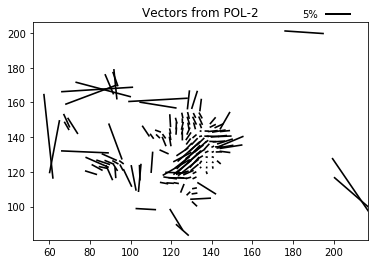

In [15]:
X, Y = wcs.wcs_world2pix(vectors['ldeg'], vectors['bdeg'], 1)
U = vectors['P'] * np.sin(np.deg2rad(90 - vectors['ANG']))
V = vectors['P'] * np.cos(np.deg2rad(90 - vectors['ANG']))
plt.figure()
plt.title('Vectors from POL-2')
Q = plt.quiver(X, Y, U, V, headaxislength=0, headlength=0, pivot='middle', headwidth=1)
qk = plt.quiverkey(Q, 0.8, 0.91, 5, r'5%', labelpos='W', coordinates='figure')

# Plotting Intensity vs % Polarization 

Same as right hand plot in Figure 8 in Archana's Oph-B paper

Text(0,0.5,'Polarization (%)')

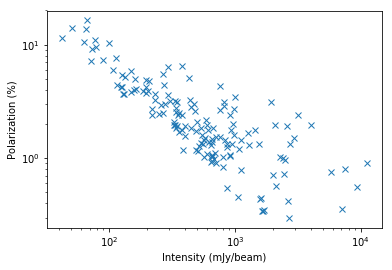

In [16]:
plt.loglog(vectors['I'],(vectors['P']),marker='x',linestyle='None')
plt.xlabel('Intensity (mJy/beam)')
plt.ylabel('Polarization (%)')


Power-law fitting is best done by first converting
to a linear equation and then fitting to a straight line.

y = a * x^b

log(y) = log(a) + b*log(x)

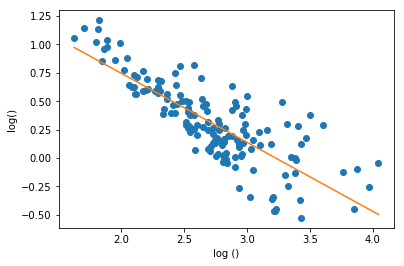

 
-0.6074 x + 1.961
1.9613873330642635 91.4928872878636 -0.6073509276402025


In [17]:
logx = np.log10(vectors['I'])
logy = np.log10(vectors['P'])

z = np.polyfit(logx, logy, 1)
f = np.poly1d(z)
logx_fit = np.linspace(min(logx), max(logx), 50)
logy_fit = f(logx_fit)
plt.plot(logx,logy,'o', logx_fit, logy_fit)
plt.title('')
plt.xlabel('log ()')
plt.ylabel('log()')
plt.show()
print (f)
b = f[1]
loga = f[0]
a = 10**loga
print (loga,a,b)

Text(0,0.5,'Polarization (%)')

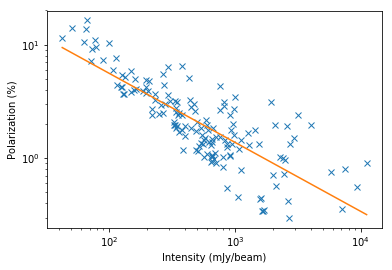

In [18]:
x1 = min(vectors['I'])
x2 = max(vectors['I'])

y1 = a * x1**(b)
y2 = a * x2**(b)
plt.loglog(vectors['I'],(vectors['P']),marker='x',linestyle='None')
plt.loglog([x1,x2],[y1,y2])
plt.xlabel('Intensity (mJy/beam)')
plt.ylabel('Polarization (%)')

# Plotting Intensity vs % Polarization (ii)


In [19]:

xdata = np.array(vectors['I'])
ydata = np.array(vectors['P'])

xerr = np.array(vectors['DI'])
yerr = np.array(vectors['DP'])

print (len(xdata),len(ydata),len(xerr),len(yerr))
print (type(xdata))


151 151 151 151
<class 'numpy.ndarray'>


[ 1.649385   -0.42672298]
[[ 0.00164096 -0.00050527]
 [-0.00050527  0.00015869]]
44.6051495012871 -0.4267229823439364
<class 'scipy.stats._distn_infrastructure.rv_frozen'>


ValueError: x and y must have same first dimension, but have shapes (151,) and (1,)

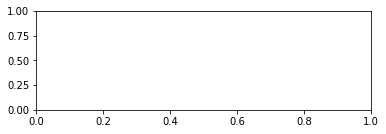

In [20]:
# work taken from: http://scipy-cookbook.readthedocs.io/items/FittingData.html
from scipy import optimize
from scipy.stats import powerlaw


##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
# Note that the `logyerr` term here is ignoring a constant prefactor.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print (pfinal)
print (covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

##########
# Plotting data
##########

plt.clf()
plt.subplot(2, 1, 1)

print (amp, index)

fittodata = powerlaw(xdata, amp, index)

print (fittodata)
print (type(fittodata))

## use for loop to fit function to data? as data is in column not np.array!?!?


plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
#plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
#plt.text(5, 6.5, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
#plt.text(5, 5.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
#plt.title('Best Fit Power Law')
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.xlim(1, 11)

#plt.subplot(2, 1, 2)
#plt.loglog(xdata, powerlaw(xdata, amp, index))
#plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
#plt.xlabel('X (log scale)')
#plt.ylabel('Y (log scale)')
#plt.xlim(1.0, 11)

In [ ]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

##########
# Generate data points with noise
##########
num_points = 20

# Note: all positive, non-zero data
xdata = np.linspace(1.1, 10.1, num_points)
ydata = powerlaw(xdata, 10.0, -2.0)     # simulated perfect data
yerr = 0.2 * ydata                      # simulated errors (10%)

ydata += np.random.randn(num_points) * yerr       # simulated noisy data


print (len(xdata),len(ydata),len(yerr))
print (type(yerr))

In [ ]:
##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
# Note that the `logyerr` term here is ignoring a constant prefactor.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err


print('fitfunc: {} '.format(fitfunc))
print('errfunc: {} '.format(errfunc))

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

print('out: {} '.format(out))


pfinal = out[0]
covar = out[1]
print (pfinal)
print (covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

##########
# Plotting data
##########

plt.clf()
plt.subplot(2, 1, 1)
plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.text(5, 6.5, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(5, 5.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(1, 11)

plt.subplot(2, 1, 2)
plt.loglog(xdata, powerlaw(xdata, amp, index))
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.xlim(1.0, 11)

# Plotting vectors in Aplpy

Using show_lines

In [20]:
# create start and end positions for the vectors I want to plot using show_lines

# once for vectors:


#vectors.remove_column('bvectors')

try:
    if vectors['bvectors'].any:
        print ('column exists')
except:
    print ('column does not exist')
    
    bvectors = []

    for x in range(len(vectors['X'])):
        l = vectors['ldeg'][x]
        b = vectors['bdeg'][x]
        pp = vectors['P'][x]
        ang = vectors['ANG'][x]
        xfactor = np.sin(np.deg2rad(90 - ang))
        yfactor = np.cos(np.deg2rad(90 - ang))
        xextent = (0.001) * pp * np.sin(np.deg2rad(90 - ang))
        yextent = (0.001) * pp * np.cos(np.deg2rad(90 - ang))
        lstart = l + (xextent/2)
        lend =  l - (xextent/2)
        bstart = b - (yextent/2) # recall b is plotted right to left
        bend = b + (yextent/2) # recall b is plotted right to left
        bvector = [[lstart,lend],[bstart,bend]]
        bvectors.append(bvector)

    print (l,b,pp,ang)
    print (ang, xfactor,yfactor, xextent,yextent)
    print (bvector)
    bvectors = Column(bvectors, name='bvectors')
   
    vectors.add_columns([bvectors])
    print ('added vectors[bvectors]')

print (vectors['bvectors'][-1])


# again for vectors3



try:
    if vectors3['bvectors'].any:
        print ('column exists')
except:
    print ('column does not exist')
    
    bvectors = []

    for x in range(len(vectors3['X'])):
        l = vectors3['ldeg'][x]
        b = vectors3['bdeg'][x]
        pp = vectors3['P'][x]
        ang = vectors3['ANG'][x]
        xfactor = np.sin(np.deg2rad(90 - ang))
        yfactor = np.cos(np.deg2rad(90 - ang))
        xextent = (0.001) * pp * np.sin(np.deg2rad(90 - ang))
        yextent = (0.001) * pp * np.cos(np.deg2rad(90 - ang))
        lstart = l + (xextent/2)
        lend =  l - (xextent/2)
        bstart = b - (yextent/2) # recall b is plotted right to left
        bend = b + (yextent/2) # recall b is plotted right to left
        bvector = [[lstart,lend],[bstart,bend]]
        bvectors.append(bvector)

    print (l,b,pp,ang)
    print (ang, xfactor,yfactor, xextent,yextent)
    print (bvector)
    bvectors = Column(bvectors, name='bvectors')
   
    vectors3.add_columns([bvectors])
    print ('added vectors3[bvectors]')

print (vectors3['bvectors'][-1])





# once for vectors450:


#vectors450.remove_column('bvectors')

try:
    if vectors450['bvectors'].any:
        print ('column exists')
except:
    print ('column does not exist')
    
    bvectors = []

    for x in range(len(vectors450['X'])):
        l = vectors450['ldeg'][x]
        b = vectors450['bdeg'][x]
        pp = vectors450['P'][x]
        ang = vectors450['ANG'][x]
        xfactor = np.sin(np.deg2rad(90 - ang))
        yfactor = np.cos(np.deg2rad(90 - ang))
        xextent = (0.001) * pp * np.sin(np.deg2rad(90 - ang))
        yextent = (0.001) * pp * np.cos(np.deg2rad(90 - ang))
        lstart = l + (xextent/2)
        lend =  l - (xextent/2)
        bstart = b - (yextent/2) # recall b is plotted right to left
        bend = b + (yextent/2) # recall b is plotted right to left
        bvector = [[lstart,lend],[bstart,bend]]
        bvectors.append(bvector)

    print (l,b,pp,ang)
    print (ang, xfactor,yfactor, xextent,yextent)
    print (bvector)
    bvectors = Column(bvectors, name='bvectors')
   
    vectors450.add_columns([bvectors])
    print ('added vectors450[bvectors]')

print (vectors450['bvectors'][-1])


# again for vectors3450



try:
    if vectors3450['bvectors'].any:
        print ('column exists')
except:
    print ('column does not exist')
    
    bvectors = []

    for x in range(len(vectors3450['X'])):
        l = vectors3450['ldeg'][x]
        b = vectors3450['bdeg'][x]
        pp = vectors3450['P'][x]
        ang = vectors3450['ANG'][x]
        xfactor = np.sin(np.deg2rad(90 - ang))
        yfactor = np.cos(np.deg2rad(90 - ang))
        xextent = (0.001) * pp * np.sin(np.deg2rad(90 - ang))
        yextent = (0.001) * pp * np.cos(np.deg2rad(90 - ang))
        lstart = l + (xextent/2)
        lend =  l - (xextent/2)
        bstart = b - (yextent/2) # recall b is plotted right to left
        bend = b + (yextent/2) # recall b is plotted right to left
        bvector = [[lstart,lend],[bstart,bend]]
        bvectors.append(bvector)

    print (l,b,pp,ang)
    print (ang, xfactor,yfactor, xextent,yextent)
    print (bvector)
    bvectors = Column(bvectors, name='bvectors')
   
    vectors3450.add_columns([bvectors])
    print ('added vectors3450[bvectors]')

print (vectors3450['bvectors'][-1])

column does not exist
0.4927904226685217 -0.7861230375633254 7.56189 -3.8321834
-3.8321834 0.9977640844622803 -0.06683436060251925 0.007544982377649028 -0.000505394091469236
[[0.4965629138573462, 0.4890179314796972], [-0.7858703405175907, -0.78637573460906]]
added vectors[bvectors]
[[ 0.49656291  0.48901793]
 [-0.78587034 -0.78637573]]
column does not exist
0.5427956023020158 -0.7561232476042674 11.636036 45.067684
45.067684 0.7062709744980883 0.7079416011095271 0.008218194427940693 0.008237633899198949
[[0.5469046995159862, 0.5386865050880455], [-0.7602420645538669, -0.7520044306546679]]
added vectors3[bvectors]
[[ 0.5469047   0.53868651]
 [-0.76024206 -0.75200443]]
column does not exist
0.5427954037586278 -0.848346110914024 1.7375392 22.605019
22.605019 0.9231765526183503 0.38437618643159766 0.0016040554230055935 0.0006678686807751985
[[0.5435974314701306, 0.5419933760471249], [-0.8486800452544117, -0.8480121765736364]]
added vectors450[bvectors]
[[ 0.54359743  0.54199338]
 [-0.84868

In [23]:
#vectors.show_in_notebook()

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmax to  3.865e+00 [aplpy.core]


/local/python/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting resolution to 38.8521 dpi [aplpy.core]
INFO: Auto-setting resolution to 38.8521 dpi [aplpy.core]


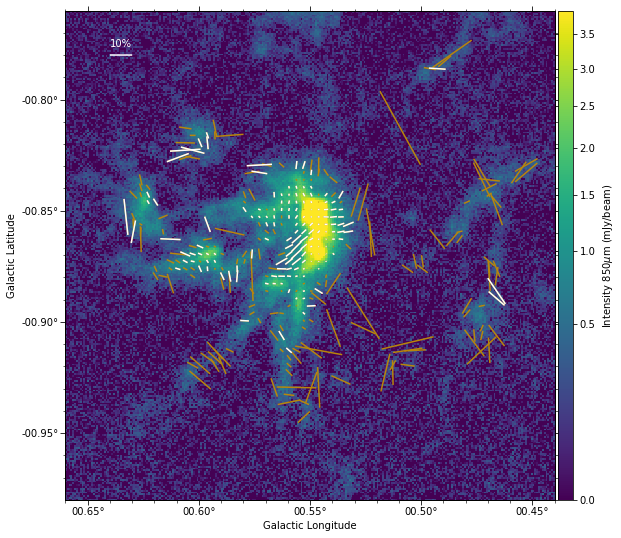

In [31]:
figpoli = aplpy.FITSFigure(fits850) # use ifits or fits850

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('Intensity 850$\mu$m (mJy/beam)') # if uising ifits = pW if using fits850 = Intensity 850$\mu$m (mJy/beam)

figpoli.recenter(0.55, -0.87, width=0.22, height=0.22)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.ticks.show_x()
figpoli.ticks.show_y()
figpoli.ticks.set_color('black')
figpoli.ticks.set_length(5) 


# Add vectors3:

for x in range(len(vectors3['X'])):
    v = vectors3['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='darkgoldenrod') # these are the 3sigma vectors

# Add vectors:

for x in range(len(vectors['X'])):
    v = vectors['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='w') # these are the 5 sigma vectors

# Create and add key:

diff = 0.001*10 # showing the 10% level
xposs = 0.63
xpose = xposs + diff
ypos = -0.78

figpoli.show_lines([np.array([[xposs,xpose],[ypos,ypos]])],color='w')
figpoli.add_label(0.635, -0.775, '10%',color='w')


try: # if on mac save here:
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2.pdf')
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2.png')
except: # if on kukui save here:
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2.pdf')
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2.png')



INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmax to  3.865e+00 [aplpy.core]


/local/python/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]
INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]


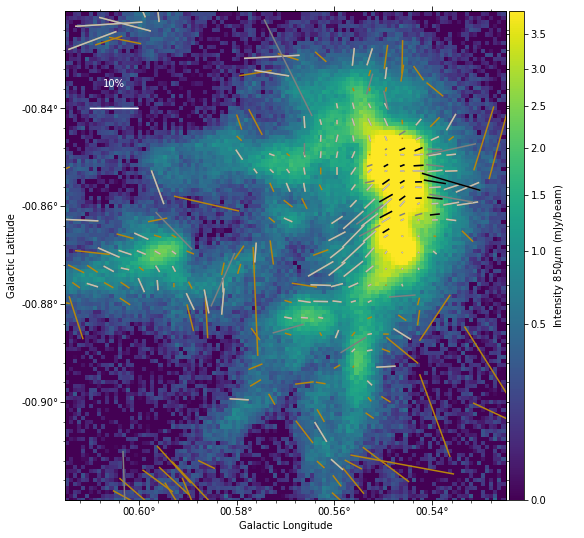

In [32]:
figpoli = aplpy.FITSFigure(fits850) # use ifits or fits850

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('Intensity 850$\mu$m (mJy/beam)') # if uising ifits = pW if using fits850 = Intensity 850$\mu$m (mJy/beam)

figpoli.recenter(0.57, -0.87, width=0.09, height=0.1)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.ticks.show_x()
figpoli.ticks.show_y()
figpoli.ticks.set_color('black')
figpoli.ticks.set_length(5) 


# Add vectors3:

for x in range(len(vectors3['X'])):
    v = vectors3['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='darkgoldenrod') # these are the 3sigma vectors

# Add vectors:

for x in range(len(vectors['X'])):
    v = vectors['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='silver') # these are the 5 sigma vectors

    

# Add vectors3450:

for x in range(len(vectors3450['X'])):
    v = vectors3450['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='gray') # these are the 3sigma vectors

# Add vectors450:

for x in range(len(vectors450['X'])):
    v = vectors450['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='black') # these are the 5 sigma vectors

    
# Create and add key:

diff = 0.001*10 # showing the 10% level
xposs = 0.60
xpose = xposs + diff
ypos = -0.84

figpoli.show_lines([np.array([[xposs,xpose],[ypos,ypos]])],color='w')
figpoli.add_label(xposs+0.005, ypos+0.005, '10%',color='w')


try: # if on mac save here:
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-and-450um.pdf')
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-450um.png')
except: # if on kukui save here:
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-450um.pdf')
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-450um.png')

# Plot POL-2 Vectors with CO outflow overlaid

In [30]:
# GennaroYSOsTable = '/Users/hparsons/Documents/EAO/Research/JellyFish/data/Jellyfish_YSOs_gennaro.txt' # on mac
GennaroYSOsTable = '/export/data2/hparsons/FOP/JellyFish/Gennaro2012/Jellyfish_YSOs_gennaro.txt'
GennaroYSOs =  ascii.read(GennaroYSOsTable)

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmax to  3.865e+00 [aplpy.core]


/local/python/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]
INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]
INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]
INFO: Auto-setting resolution to 17.66 dpi [aplpy.core]


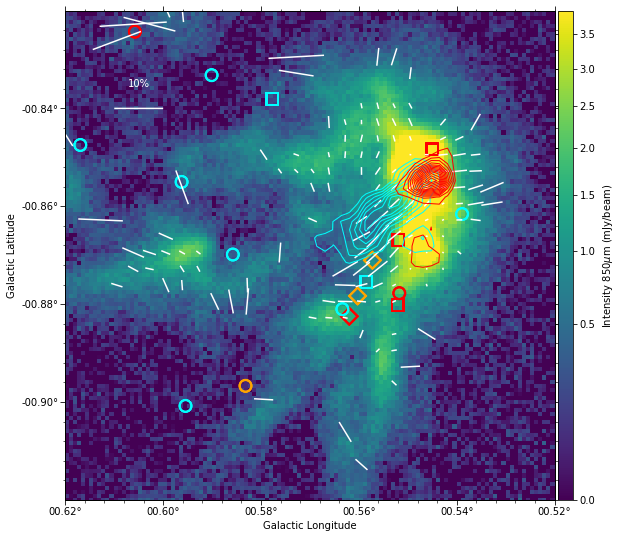

In [35]:
figpoli = aplpy.FITSFigure(fits850) # use ifits or fits850

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # colour options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('Intensity 850$\mu$m (mJy/beam)') # if uising ifits = pW if using fits850 = Intensity 850$\mu$m (mJy/beam)

figpoli.recenter(0.57, -0.87, width=0.10, height=0.10)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.ticks.show_x()
figpoli.ticks.show_y()
figpoli.ticks.set_color('black')
figpoli.ticks.set_length(5) 

# Add vectors:

for x in range(len(vectors['X'])):
    v = vectors['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='w')


# Create and add key:

diff = 0.001*10 # showing the 10% level
xposs = 0.60
xpose = xposs + diff
ypos = -0.84

figpoli.show_lines([np.array([[xposs,xpose],[ypos,ypos]])],color='w')
figpoli.add_label(0.605, -0.835, '10%',color='w')

# overplotting CO contours

#figpoli.show_contour(fitsfile_12co_tex, levels=[70,75,80,85,90,95,100,105,110,115,120], colors='white', linewidths=0.8)

co_integ_contourlevels = np.arange(25, 160, 10)
figpoli.show_contour(fitsfile_12co_integhigh, levels=co_integ_contourlevels, colors='aqua', linewidths=1.0)
figpoli.show_contour(fitsfile_12co_integlow, levels=co_integ_contourlevels, colors='red', linewidths=1.0)

try: # if on mac save here:
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-outflow.pdf')
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-outflow.png')
except: # if on kukui save here:
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-outflow.pdf')
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-outflow.png')




for x in range(len(GennaroYSOs['l'])):
    l = GennaroYSOs['l'][x]
    b = GennaroYSOs['b'][x]
    YSO_type = GennaroYSOs['Type'][x]
    YSO_JHK = GennaroYSOs['JHK'][x]
#    print (l,b,YSO_type, YSO_JHK)
    if YSO_type == 1:
        markercolor='red'
    if YSO_type == 2:
        markercolor="aqua"
    if YSO_type == 3:
        markercolor="orange"
    if YSO_JHK == 0.0:
        markermarker ='x' # crosses
    if YSO_JHK == 1.0:
        markermarker ='D' # diamonds
    if YSO_JHK == 2.0:
        markermarker ='s' # Squares
    if YSO_JHK == 3.0:
        markermarker ='o' # Circles
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=110, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=120, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=130, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=140, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=150, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=160, alpha=1.0) # , facecolor='none'
    figpoli.show_markers(l,b, edgecolor=markercolor, marker=markermarker, s=170, alpha=1.0) # , facecolor='none'


try: # if on mac save here:
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-outflow-ysos.pdf')
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-sc2-pol2-outflow-ysos.png')
except: # if on kukui save here:
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-outflow-ysos.pdf')
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-sc2-pol2-outflow-ysos.png')




# POL2 Vectors with CO Intensity Weighted Dispersion displayed

INFO: Setting slices=[0] [aplpy.core]


/local/python/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting resolution to 8.83002 dpi [aplpy.core]
INFO: Auto-setting resolution to 8.83002 dpi [aplpy.core]


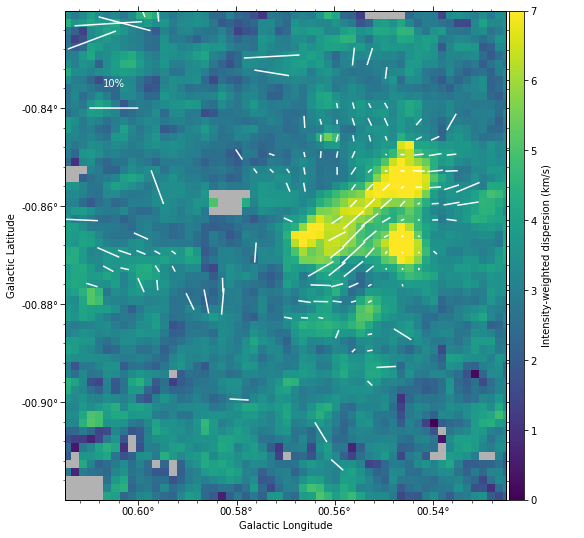

In [26]:
figpoli = aplpy.FITSFigure(fitsfile_12co_iwd) # use ifits or fits850

figpoli.show_colorscale(vmin=0.0,vmax=7.0,cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('Intensity-weighted dispersion (km/s)') # if uising ifits = pW if using fits850 = Intensity 850$\mu$m (mJy/beam)

figpoli.recenter(0.57, -0.87, width=0.09, height=0.10)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.ticks.show_x()
figpoli.ticks.show_y()
figpoli.ticks.set_color('black')
figpoli.ticks.set_length(5) 

# Add vectors:

for x in range(len(vectors['X'])):
    v = vectors['bvectors'][x]
    figpoli.show_lines([np.array(v)],color='w')


# Create and add key:

diff = 0.001*10 # showing the 10% level
xposs = 0.60
xpose = xposs + diff
ypos = -0.84

figpoli.show_lines([np.array([[xposs,xpose],[ypos,ypos]])],color='w')
figpoli.add_label(0.605, -0.835, '10%',color='w')


try: # if on mac save here:
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-iwd-pol2.pdf')
    figpoli.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-iwd-pol2.png')
except: # if on kukui save here:
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-iwd-pol2.pdf')
    figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/images/Jellyfish-iwd-pol2.png')



In [3]:
fitsfile_irac_8um = '/Users/hparsons/Documents/EAO/Research/JellyFish/data/IRAC-8um/Level2PBCDIRAC8um_align.fits'
fitsfile_s850_integ = '/Users/hparsons/Documents/EAO/Research/JellyFish/data/scuba2/850um_corr_map_mJybeam_2D.fits'
fitsfile_12co_integ = '/Users/hparsons/Documents/EAO/Research/JellyFish/data/12co/CO_cube_field_South_1_integ.fits'
position_Jelly = SkyCoord(l=0.57*u.degree, b=-0.87*u.degree, frame='galactic')
position_Jelly.fk5.ra.deg

267.5924230182249

In [4]:
irac8um_im = aplpy.FITSFigure(fitsfile_irac_8um)
irac8um_im.show_colorscale(vmin=0,cmap='magma',stretch='sqrt') # 
#irac8um_im.recenter(position_Jelly.fk5.ra.deg,position_Jelly.fk5.dec.deg, width=0.16, height=0.16)
irac8um_im.recenter(position_Jelly.l.deg,position_Jelly.b.deg, width=0.16, height=0.16)

sc2_integ_contourlevels = np.arange(0.5, 30, 1)
co_integ_contourlevels = np.arange(50, 800, 50)
#print (co_integ_contourlevels)

irac8um_im.show_contour(fitsfile_s850_integ, levels=sc2_integ_contourlevels, colors='black', linewidths=1.0)
irac8um_im.show_contour(fitsfile_12co_integ, levels=[100.0], colors='white', linewidths=0.8)

#irac8um_im.show_markers(0.6,-0.9,color="green")

irac8um_im.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-irac8um-contours-vectors.pdf')
irac8um_im.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-irac8um-contours-vectors.png')

INFO: Auto-setting vmax to  5.346e+02 [aplpy.core]
INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting resolution to 24.7742 dpi [aplpy.core]


/Users/hparsons/anaconda/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


# Other Vector Plot Method

The following works but I'm setting as Markdown. Using aplpy for ease and consistency:

In [ ]:
fitsfile = ifits

from astropy.visualization import wcsaxes
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u

#Get the first HDU of the FITS file as a numpy array.
hdu = fits.open(fitsfile)[0]
wcs = WCS(hdu.header)
#print (wcs)

# Our image is actually a 3-D cube with a single dimension in the spectral dimension,
# so we will remove that from the wCS and from the data
wcs = wcs.dropaxis(2)
data = hdu.data[0,:,:]

fig = plt.figure(figsize=(10,10))
ax = wcsaxes.WCSAxesSubplot(fig, 1,1,1, wcs=wcs)
fig.add_axes(ax)

#Show the image -- we want to include the data limits to scale to, and also we have to set origin='lower'
# as FITS files set a different pixel origin that matplotlib assumes
image = ax.imshow(data, vmin=0, vmax=0.00175, origin='lower', interpolation='none') # vmin=-2, vmax=8, ,cmap='viridis',


# to do: re-size the area we are showing

# to do: set the colour scaling to sqrt


#Now add a colorbar.
cbar = fig.colorbar(image)
cbar.set_label('pW')#'mJy beam$^{-1}$')

# Add a grid.
ax.grid(color='0.7', alpha=0.5)

# Add contours
##ax.contour(data, colors='black', linewidths=0.5)


# Now add vectors
quiv = ax.quiver(X, Y, U, V, color='white',
                 headaxislength=0, headlength=0, pivot='middle', headwidth=1) 
qk = ax.quiverkey(Q, 0.8, 0.95, 5, r'5%', labelpos='W', coordinates='figure',labelcolor='grey',color='grey') #NOT WORKING


# Working on the axes

ax.set_xlabel('Galactic Longitude (deg)')
ax.set_ylabel('Galactic Latitude (deg)')

l = ax.coords[0]
l.display_minor_ticks(True)
l.set_major_formatter('d.ddd')
l.set_ticks(spacing=0.05*u.deg)

b = ax.coords[1]
b.display_minor_ticks(True)
b.set_major_formatter('d.ddd')
b.set_ticks(spacing=0.05*u.deg)

###fig.savefig('g34-image-wcsaxes.pdf')


#fig.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-plo2-sc2.pdf')
#fig.savefig('/Users/hparsons/Documents/EAO/Research/JellyFish/images/Jellyfish-plo2-sc2.png')

## Plotting image using Aplpy

I find it easier to use aplpy to plot my intensity pol2 image. However what I find is wen I overplot the SCUBA-2 data I do not return the same strucutre in my final image. 

> show_lines

In [ ]:
figpoli = aplpy.FITSFigure(ifits)

figpoli.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis') # magma or plasma also options: https://matplotlib.org/examples/color/colormaps_reference.html

figpoli.set_nan_color('0.7')

figpoli.add_colorbar()

figpoli.colorbar.set_axis_label_text('pW')

figpoli.recenter(0.575, -0.87, width=0.2, height=0.22)

figpoli.tick_labels.set_xformat('ddd.dd')
figpoli.tick_labels.set_yformat('ddd.dd')

figpoli.show_contour(fits850, levels=[0.5,1,2,4], colors='orange') # plotting 850um SCUBA-2 over the top
figpoli.show_contour(ifitssnr, levels=[10],colors='white')


figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/Jellyfish-pol2-contours.pdf')
figpoli.savefig('/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/Jellyfish-pol2-contours.png')

#figpoli.show_lines # how I hope to overplot my 

### Visual inspection of various POL-2 reductions (the total intesnsity maps)

In [ ]:
def explore_pol2_plot(iauto,iext,astmask,pcamask,outname):
    '''
    This function will take four fits maps - the iauto, 
    iext the ast mask and the pca mask and visulise them
    it will produce an output image saved under outname
    '''
    
    fig = plt.figure(figsize=(14,14))

    fa = aplpy.FITSFigure(iauto, figure=fig, subplot=[0.1,0.5,0.35,0.35])
    fa.recenter(0.575, -0.87, width=0.16, height=0.22)
    fa.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis')
    fa.set_title(iauto)
    fa.tick_labels.set_xformat('ddd.dd')
    fa.tick_labels.set_yformat('ddd.dd')

    fe = aplpy.FITSFigure(iext, figure=fig, subplot=[0.5,0.5,0.35,0.35])
    fe.recenter(0.575, -0.87, width=0.16, height=0.22)
    fe.show_colorscale(0,0.00175,stretch='sqrt',cmap='viridis')
    fe.add_colorbar()
    fe.set_title("externally masked")
    fe.colorbar.set_axis_label_text('pW')
    fe.tick_labels.set_xformat('ddd.dd')

    fe.hide_yaxis_label()
    fe.hide_ytick_labels()
    
    fm = aplpy.FITSFigure(astmask, figure=fig, subplot=[0.1,0.1,0.35,0.35])
    fm.set_title("The ast mask")
    fm.recenter(0.575, -0.87, width=0.16, height=0.22)
    fm.show_colorscale(cmap='plasma')
    fm.tick_labels.set_xformat('ddd.dd')
    fm.tick_labels.set_yformat('ddd.dd')
    
    fp = aplpy.FITSFigure(pcamask, figure=fig, subplot=[0.5,0.1,0.35,0.35])
    fp.set_title("The pca mask")
    fp.recenter(0.575, -0.87, width=0.16, height=0.22)
    fp.show_colorscale(cmap='magma')
    fp.tick_labels.set_xformat('ddd.dd')
    
    fp.hide_yaxis_label()
    fp.hide_ytick_labels()
    
    fig.savefig(outname)


In [ ]:
# files to plot REDUCTION

ndfi = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/iext.sdf' # absolute file path
ndfiauto = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/iauto.sdf' # absolute file path
ndfastmask = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/astmask.sdf' # absolute file path
ndfpcamask = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/Reduction/pixel4asec/pcamask.sdf' # absolute file path

outname = '/export/data2/hparsons/FOP/JellyFish/POL2/pol2map/images/reduction4asec.pdf'

# quick fits check

fitsi = convert_ndf_to_fits(ndfi)
fitsiauto = convert_ndf_to_fits(ndfiauto)
fitsastmask = convert_ndf_to_fits(ndfastmask)
fitspcamask = convert_ndf_to_fits(ndfpcamask)

# produce the plots

explore_pol2_plot(fitsiauto,fitsi,fitsastmask,fitspcamask,outname)